In [1]:
# Import packages
library(tidyverse)
library(bnlearn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘bnlearn’


The following object is masked from ‘package:stats’:

    sigma




# File paths

In [2]:
met_source = 'metno' # choose from 'metno' or 'era5'

# End year of desired training data (check BayesianNetwork/Data/BN_TrainingData folder for available date ranges)
end_yr_li = list('metno'=2018,
                 'era5'=2019)

# File path to training data matrix (includes all available data, no NaN patching. Therefore maybe slightly different results to CV)
training_data_fpath = sprintf("../Data/BN_TrainingData/TrainingData_GaussianBN_%s_1981-%s.csv", met_source, end_yr_li[[met_source]])

# File path to save bn.fit object to (to be used in making predictions)
rfile_fpath = sprintf("../Data/RData/Vansjo_fitted_GaussianBN_%s_1981-%s.rds", met_source, end_yr_li[[met_source]])

# Output from fitted network
out_folder = "../Data/FittedNetworkDiagnostics"

# Create a fitted bayesian network

Save fitted network to file for use elsewhere

In [3]:
# Create the network structure manually

# Create an empty DAG with the desired nodes
nodes = c('TP',
          'TP_prevSummer',
          'chla',
          'chla_prevSummer',
          'wind_speed',
          'cyano', # N.B. boxcox transformed training data
          'colour_prevSummer',
          'colour',
          'rain'
             )

dag = empty.graph(nodes)

# Manually define the arcs connecting nodes
arcs_matrix = matrix(c('TP_prevSummer','TP',
                       'TP','chla',
                       'chla_prevSummer','chla',
                       'wind_speed','chla',
                       'chla','cyano',
                       'colour','cyano',
                       'colour_prevSummer','colour',
                       'rain','colour'
                         ),
                        ncol = 2, byrow = TRUE,
                        dimnames = list(NULL, c("from", "to"))) #assign the DAG structure (as an attribute of asia)

# Assign the structure to the empty graph using arcs, which turns it into a bnlearn object
arcs(dag) = arcs_matrix
dag


  Random/Generated Bayesian network

  model:
   [TP_prevSummer][chla_prevSummer][wind_speed][colour_prevSummer][rain]
   [TP|TP_prevSummer][colour|colour_prevSummer:rain]
   [chla|TP:chla_prevSummer:wind_speed][cyano|chla:colour]
  nodes:                                 9 
  arcs:                                  8 
    undirected arcs:                     0 
    directed arcs:                       8 
  average markov blanket size:           2.89 
  average neighbourhood size:            1.78 
  average branching factor:              0.89 

  generation algorithm:                  Empty 


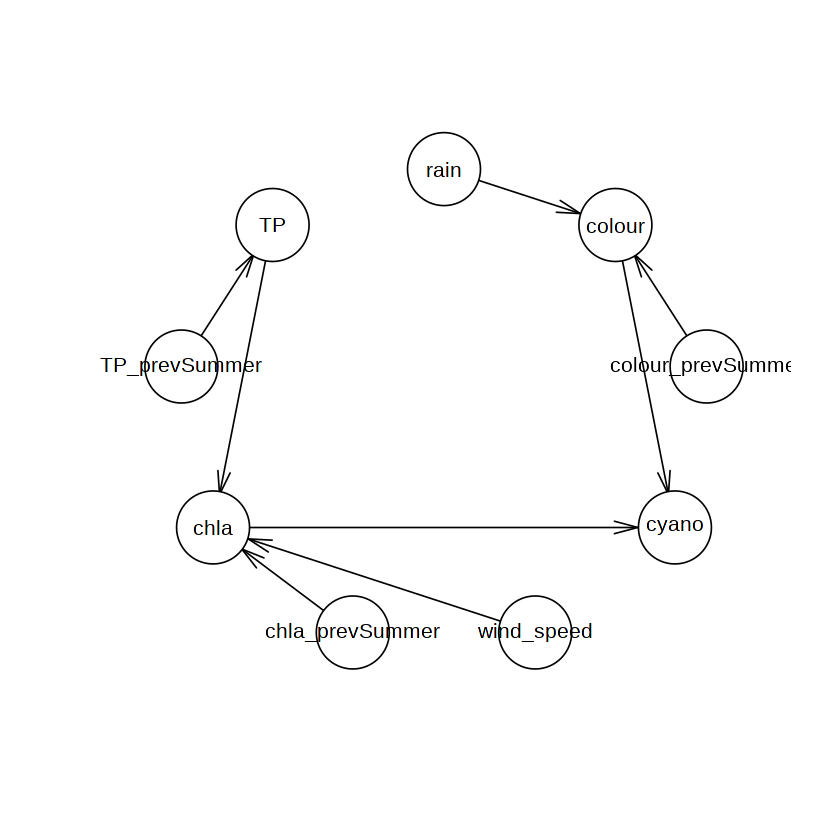

In [4]:
plot(dag)

In [20]:
# Read in historic data which will be used to fit the network params
data_cont = read.csv(file=training_data_fpath, header=TRUE, sep=",", row.names = 1)
data_cont[1:ncol(data_cont)] = lapply(data_cont[1:ncol(data_cont)], as.numeric) # Convert any integer cols to numeric
data_cont = data_cont[ , (names(data_cont) %in% nodes)] # Remove any columns that aren't present in the network nodes

# Quick look
head(data_cont)

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,494.7302,NA,28.83333,8.33125,3.488587,NA,NA,43.57302,16.08013
1982,458.4748,26.66667,26.98810,5.97500,3.818478,NA,NA,28.83333,8.33125
1983,466.6311,17.62500,29.78125,6.05000,4.247283,NA,26.66667,26.98810,5.97500
1984,561.4721,NA,27.15833,11.61111,3.796739,NA,17.62500,29.78125,6.05000
1985,548.3746,34.40476,30.95714,11.89524,3.644022,NA,NA,27.15833,11.61111
1986,429.2713,27.47222,33.78889,12.67778,4.122283,NA,34.40476,30.95714,11.89524


In [21]:
# Fit. Returns a bn.fit object, which includes fitted conditional probability tables for each node
fitted_BN = bn.fit(dag, data_cont)

# Quick look at the fitted coefficients associated with each node
coefficients(fitted_BN)

$TP
  (Intercept) TP_prevSummer 
   10.7305691     0.6117208 

$TP_prevSummer
(Intercept) 
   29.51861 

$chla
    (Intercept)              TP chla_prevSummer      wind_speed 
     15.2653069       0.4695346       0.3269989      -5.1845081 

$chla_prevSummer
(Intercept) 
   15.62922 

$wind_speed
(Intercept) 
    3.57149 

$cyano
(Intercept)        chla      colour 
-1.83536753  0.16941009 -0.02365185 

$colour_prevSummer
(Intercept) 
    41.1837 

$colour
      (Intercept) colour_prevSummer              rain 
      -7.75795173        0.81119234        0.02861366 

$rain
(Intercept) 
   514.2102

In [22]:
# Save bn.fit object to file for reading later & using to make predictions
saveRDS(fitted_BN, file = rfile_fpath )

# Save auxiliary info associated with the network

Save coefficients and standard deviations for use elsewhere

In [23]:
# Standard deviation of the residuals

# First, make an empty list and then populate it with the standard deviations
sd_li = vector(mode = "list", length = 0)
for (node in nodes(dag))
    {sd = fitted_BN[[node]]$sd
     sd_li[[node]] = sd
    }

# Then turn into a dataframe & save to csv to accompany predictions
sd_df = data.frame(node = nodes(dag), sd = unlist(sd_li, use.names=FALSE))
out_fpath = file.path(out_folder, sprintf("GBN_%s_1981-%s_stdevs.csv", met_source, end_yr_li[[met_source]]))
write.csv(sd_df,out_fpath, row.names = FALSE)

sd_df

node,sd
<fct>,<dbl>
TP,3.7958656
TP_prevSummer,5.1533997
chla,3.7389697
chla_prevSummer,5.5868686
wind_speed,0.2482299
cyano,0.7381779
colour_prevSummer,17.2734354
colour,8.9597100
rain,101.2735520


In [24]:
# Coefficients are in a named list. Doesn't seem easy to write this to text file with a nice format
# Best I've come up with so far (no label info included):
out_fpath = file.path(out_folder, sprintf("coeffs_%s_1981-%s.csv",met_source, end_yr_li[[met_source]]))
lapply(coefficients(fitted_BN), write, out_fpath, append=TRUE, ncolumns=10);

$TP
NULL

$TP_prevSummer
NULL

$chla
NULL

$chla_prevSummer
NULL

$wind_speed
NULL

$cyano
NULL

$colour_prevSummer
NULL

$colour
NULL

$rain
NULL